In [3]:
!pip install keras_tqdm
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [349]:
import random, math, csv, pickle

import keras
from keras_tqdm import TQDMNotebookCallback
from keras import backend as K
from keras import losses
from keras.models import load_model
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt 
from matplotlib import patches as mpatches

from sklearn import preprocessing
from sklearn import model_selection
import sklearn.pipeline as skp

In [350]:
#init values
link_arm_1 = 86.
link_arm_2 = 55.

#define functions
def cart_coord(thet1,thet2):
    """
    Given angles (in radians) give cartesian coordinates of the end-effector
    """
    X_coord = link_arm_1 * np.cos(thet1) + link_arm_2 * np.cos(thet2 + thet1)
    Y_coord = link_arm_1 * np.sin(thet1) + link_arm_2 * np.sin(thet2 + thet1)
    return X_coord, Y_coord

def x_cart_coord(thet1,thet2):
    """
    Given angles (in radians) give cartesian coordinates of the end-effector
    """
    X_coord = link_arm_1 * np.cos(thet1) + link_arm_2 * np.cos(thet2 + thet1)
    Y_coord = link_arm_1 * np.sin(thet1) + link_arm_2 * np.sin(thet2 + thet1)
    return X_coord

def y_cart_coord(thet1,thet2):
    """
    Given angles (in radians) give cartesian coordinates of the end-effector
    """
    X_coord = link_arm_1 * np.cos(thet1) + link_arm_2 * np.cos(thet2 + thet1)
    Y_coord = link_arm_1 * np.sin(thet1) + link_arm_2 * np.sin(thet2 + thet1)
    return Y_coord


def x_cart_coord(thet1,thet2):
    """
    Given angles (in radians) give cartesian coordinates of the end-effector
    """
    return link_arm_1 * np.cos(thet1) + link_arm_2 * np.cos(thet1+thet2)

def y_cart_coord(thet1,thet2):
    """
    Given angles (in radians) give cartesian coordinates of the end-effector
    """
    return link_arm_1 * np.sin(thet1) + link_arm_2 * np.sin(thet1+thet2)

Q1 = []
Q2 = []
posX = []
posY = []
samples = 5000


file = open ("traing_data_20052022.csv","w")                             # Data Set Creation
for i in range (0,samples):
    
    q1 = round(random.uniform(math.radians(-45.), math.radians(100.)),2)
    q2 = round(random.uniform(math.radians(0.), math.radians(360)),2)


    Q1.append(q1)
    file.write(str(q1))
    file.write(",")

    Q2.append(q2)
    file.write(str(q2))
    file.write(",")  
              
    X = x_cart_coord(q1,q2)
    posX.append(X)
    file.write(str(round(X, 2)))
    file.write(",")

    Y =y_cart_coord(q1,q2)
    posY.append(Y)
    file.write(str(round(Y, 2)))
              
    file.write("\n")

file.close()

(0.0, 150.0)

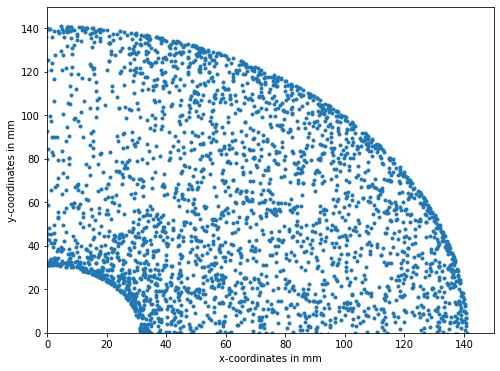

In [351]:
font_size_defined = 'x-large'
fig = plt.figure(1,figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('x-coordinates in mm')
ax1.set_ylabel('y-coordinates in mm')
ax1.scatter(posX,posY,marker='.')
ax1.set_xlim(0,150)
ax1.set_ylim(0,150)

In [352]:
data = np.c_[Q1,Q2,posX,posY] 

tol = 0.4 # minimum spacing between cartesian points in mm
indices_to_ignore = np.empty((0,1))

for i in range(0,len(data)):                         # Removing duplicated end effeector positions
    for j in range(0,len(data)):
        if i != j:
            #print(i,j,'checking..')
            # if (dataMat[j,2] == check1 and dataMat[j,3] == check2): # old code for testing whether two entries were identical
            if np.sqrt((data[i,2] - data[j,2])**2 + (data[i,3] - data[j,3])**2) < tol: # interpoint spacing 
                #print("excluded columns")
                #print(i)#,j,data[j,2],data[j,3])
                indices_to_ignore = np.append(indices_to_ignore, i)



In [353]:
dataMat = np.empty((0,4))
for row in range(len(data)):
    if row not in indices_to_ignore:
        dataMat = np.append(dataMat, [data[row]], axis=0)

(0.0, 150.0)

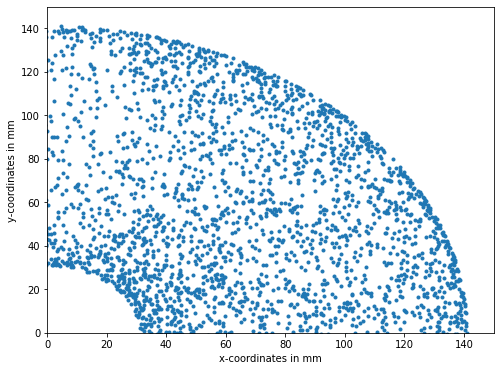

In [354]:
font_size_defined = 'x-large'
fig = plt.figure(1,figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('x-coordinates in mm')
ax1.set_ylabel('y-coordinates in mm')
ax1.scatter(dataMat[:,2],dataMat[:,3],marker='.')
ax1.set_xlim(0,150)
ax1.set_ylim(0,150)

In [355]:
# from nanpy import (ArduinoApi, SerialManager, Servo)
data_processed = dataMat

In [347]:
#dougies stuff
import itertools
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
        
def create_model(architecture = {'layers':3,'neurons':[100,100,100],'activations':['tanh','tanh','tanh']}):
    '''
    '''
    #input layer
    model1 = keras.Sequential()
    model1.add(keras.layers.Dense(2,activation='linear'))
    #add hidden layers
    for i in range(architecture['layers']):
        model1.add(keras.layers.Dense(architecture['neurons'][i],
                                      use_bias=True,
                                      activation=architecture['activations'][i]))
    
    #output layer    
    model1.add(keras.layers.Dense(2, use_bias=True, activation='linear'))
    model1.compile(optimizer = 'adam', loss=losses.mean_squared_error, metrics=['accuracy'])
    
    return model1

In [ ]:
#dougie stuff cont.
#set random state
np.random.seed(0)
#split data into training and final test set
input_data = data_processed[:,2:]
label_data = data_processed[:,:2]
input_train, input_test, label, label_test = model_selection.train_test_split(input_data, label_data, test_size=0.15)

# model2 = KerasClassifier(build_fn=create_model, epochs=200, batch_size=10, verbose=0)
model2 = KerasRegressor(build_fn=create_model, epochs=200, batch_size=10, verbose=0)

# model2 = keras.Sequential(build_fn=create_model, epochs=200, batch_size=10, verbose=0)
pipe = skp.Pipeline([('scaler',preprocessing.MinMaxScaler()),
                     ('NN',    model2)])
params = {'NN__architecture':[
                              {'layers':1,'neurons':[1],'activations':['tanh']},                         #model1
                              {'layers':2,'neurons':[2,3],'activations':['tanh','tanh']},                #model2
                              {'layers':3,'neurons':[100,100,100],'activations':['tanh','tanh','tanh']}, #model3
                              {'layers':3,'neurons':[50,100,100],'activations':['tanh','tanh','tanh']}   #model4
                               ]}
results2 = model_selection.GridSearchCV(pipe,param_grid=params,cv=5,refit=True,verbose=2).fit(input_train,label)


In [344]:
results2.best_params_

{'NN__architecture': {'layers': 3,
  'neurons': [50, 100, 100],
  'activations': ['tanh', 'tanh', 'tanh']}}

In [356]:
#split data into training and final test set
input_data = data_processed[:,2:]
label_data = data_processed[:,:2]
input_train, input_test, label, label_test = model_selection.train_test_split(input_data, label_data, test_size=0.15)

#scale
i_scaler = preprocessing.MinMaxScaler(feature_range=(-1.,1.)) #this range is for tanh
l_scaler = preprocessing.MinMaxScaler(feature_range=(-1.,1.))
i_train = i_scaler.fit_transform(input_train)
l_train = l_scaler.fit_transform(label)
i_test  = i_scaler.transform(input_test)
l_test  = l_scaler.transform(label_test)

no_ep = 200 #number of epochs

#def custom_loss(label_True,label_Pred):
#    return(K.sum((label_True-label_Pred)**2)/len(i_train))

model1 = keras.Sequential()
model1.add(keras.layers.Dense(2,activation='linear'))
model1.add(keras.layers.Dense(100, use_bias=True, activation='tanh'))
model1.add(keras.layers.Dense(100, use_bias=True, activation='tanh'))
model1.add(keras.layers.Dense(100, use_bias=True, activation='tanh')) # not really necessary but speeds up convergence
model1.add(keras.layers.Dense(2, use_bias=True, activation='linear'))

model1.compile(optimizer = 'adam', loss=custom_loss, metrics=['accuracy'])
model1.compile(optimizer = 'adam', loss=losses.mean_squared_error, metrics=['accuracy'])
model1.compile(optimizer = 'adam', loss=losses.logcosh, metrics=['accuracy'])

results = model1.fit(i_train,l_train, validation_split=0.15, epochs=no_ep, verbose=0)#, callbacks=[TQDMNotebookCallback()])

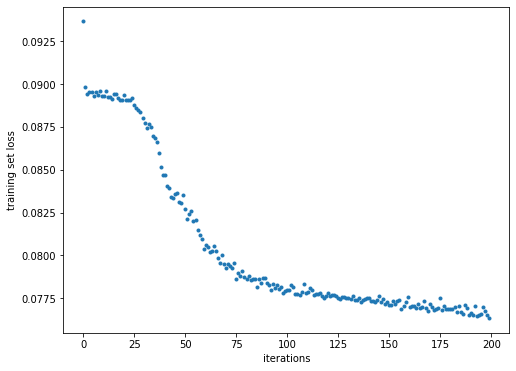

In [357]:
#plot cost on training set
font_size_defined = 'x-large'
fig = plt.figure(1,figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('iterations')
ax1.set_ylabel('training set loss')
ax1.scatter(np.array(range(no_ep)),results.history['loss'],marker='.')

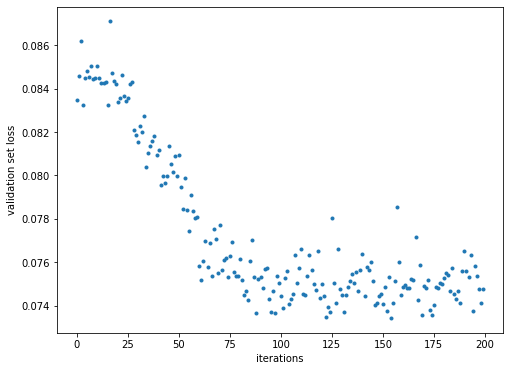

In [358]:
#plot cost on validation set
font_size_defined = 'x-large'
fig2 = plt.figure(1,figsize=(8,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.set_xlabel('iterations')
ax2.set_ylabel('validation set loss')
ax2.scatter(np.array(range(no_ep)),results.history['val_loss'],marker='.')

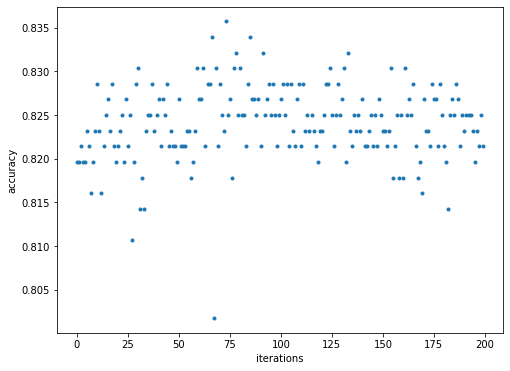

In [359]:
#plot accuracy
font_size_defined = 'x-large'
fig3 = plt.figure(1,figsize=(8,6))
ax3 = fig3.add_subplot(1,1,1)
ax3.set_xlabel('iterations')
ax3.set_ylabel('accuracy')
ax3.scatter(np.array(range(no_ep)),results.history['val_accuracy'],marker='.')

In [360]:
data_input = i_scaler.transform(data[:,2:])
test_prediction = model1.predict(data_input)
real_prediction = l_scaler.inverse_transform(test_prediction)

157/157 [==============================] - 0s 1ms/step


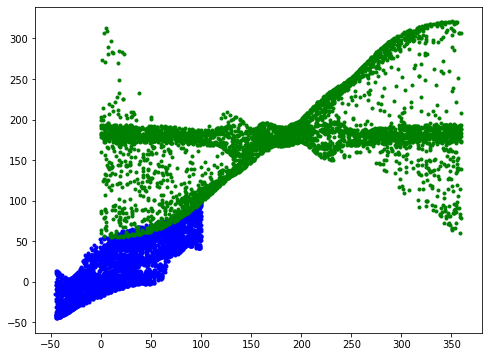

In [361]:
font_size_defined = 'x-large'
fig5 = plt.figure(1,figsize=(8,6))
ax5 = fig5.add_subplot(1,1,1)
#ax5.set_xlabel('true angles')
#ax5.set_ylabel('predicted angles')
ax5.scatter(np.degrees(data[:,0]),np.degrees(real_prediction[:,0]),c='b',marker='.')
ax5.scatter(np.degrees(data[:,1]),np.degrees(real_prediction[:,1]),c='g',marker='.')
#ax5.scatter(np.degrees(data[:,0]),np.degrees(theta_pred),color='g',marker='.')#,label='PRED')

In [377]:
def frac_coords_from_xy(path_to_xy_file):
    '''
    generate fraction_coordinates dictionary given output from get_coords_from_pic.py script
    at the moment, 'fraction' string is prepended to every coordinate. if a 'waste' string is desired, it will need to be manually changed instead.

    first element of xy file contains the origin i.e. location of spindle relative to the fraction tubes and this is set to zero. 
    '''
    with open(path_to_xy_file, 'rb') as f:
        xy = pickle.load(f)

    xy = xy[1:] # drop the first element of the array because it contains the location of the spindle and not fraction tubes

    frac_labels = []

    for elem in range(len(xy)):
        frac_labels.append('fraction'+str(elem))
    
    return dict(zip(frac_labels,xy))

In [378]:
test_coords = frac_coords_from_xy('test_coords_20052022.pickle')

In [379]:
x = np.asarray(list(test_coords.values())).transpose()[0]
y = np.asarray(list(test_coords.values())).transpose()[1]

In [380]:
test_coords

{'fraction0': array([69.96694215, 37.50617284]),
 'fraction1': array([85.14049587, 37.12345679]),
 'fraction2': array([102.        ,  37.88888889]),
 'fraction3': array([118.43801653,  37.12345679]),
 'fraction4': array([133.61157025,  37.12345679]),
 'fraction5': array([69.96694215, 53.96296296]),
 'fraction6': array([85.98347107, 53.58024691]),
 'fraction7': array([102.4214876 ,  53.19753086]),
 'fraction8': array([118.01652893,  52.81481481]),
 'fraction9': array([134.45454545,  53.19753086]),
 'fraction10': array([69.54545455, 68.12345679]),
 'fraction11': array([85.98347107, 67.74074074]),
 'fraction12': array([102.4214876 ,  67.35802469]),
 'fraction13': array([117.59504132,  67.35802469])}

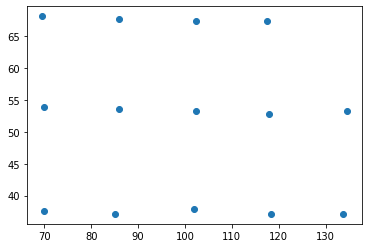

In [381]:
plt.scatter(x,y)
# the plot gives the expected result; all positions of the fraction tubes are accounted for

In [383]:
def q2_from_cart(x, y):
    return np.arccos( (x**2 + y**2 - link_arm_1**2 - link_arm_2**2) / (2 * link_arm_1 * link_arm_2) )

def q1_from_cart(x, y):
    theta2 = np.arccos( (x**2 + y**2 - link_arm_1**2 - link_arm_2**2) / (2 * link_arm_1 * link_arm_2) )
    return np.arctan(y / x) - np.arctan( link_arm_2 * np.sin(theta2) / ( link_arm_1 + link_arm_2 * np.cos(theta2) ))

In [384]:
test_

{'fraction0': array([69.96694215, 37.50617284]),
 'fraction1': array([85.14049587, 37.12345679]),
 'fraction2': array([102.        ,  37.88888889]),
 'fraction3': array([118.43801653,  37.12345679]),
 'fraction4': array([133.61157025,  37.12345679]),
 'fraction5': array([69.96694215, 53.96296296]),
 'fraction6': array([85.98347107, 53.58024691]),
 'fraction7': array([102.4214876 ,  53.19753086]),
 'fraction8': array([118.01652893,  52.81481481]),
 'fraction9': array([134.45454545,  53.19753086]),
 'fraction10': array([69.54545455, 68.12345679]),
 'fraction11': array([85.98347107, 67.74074074]),
 'fraction12': array([102.4214876 ,  67.35802469]),
 'fraction13': array([117.59504132,  67.35802469])}

In [387]:
fraction_coords_polar = test_coords.copy()

for elem in test_coords.keys():
    fraction_coords_polar[elem] = np.array([q1_from_cart(test_coords[elem][0], test_coords[elem][1]), \
                                           q2_from_cart(test_coords[elem][0], test_coords[elem][1])])

/tmp/ipykernel_1205/2389967553.py:5: RuntimeWarning: invalid value encountered in arccos
  theta2 = np.arccos( (x**2 + y**2 - link_arm_1**2 - link_arm_2**2) / (2 * link_arm_1 * link_arm_2) )
/tmp/ipykernel_1205/2389967553.py:2: RuntimeWarning: invalid value encountered in arccos
  return np.arccos( (x**2 + y**2 - link_arm_1**2 - link_arm_2**2) / (2 * link_arm_1 * link_arm_2) )


In [386]:
# fraction_coords_polar = test_coords.copy()

# for elem in test_coords.keys():
#     fraction_coords_polar[elem] = np.degrees(model1.predict(i_scaler.transform(test_coords[elem].reshape((1,2)))))

In [388]:
fraction_coords_polar

{'fraction0': array([-0.18139469,  2.02128241]),
 'fraction1': array([-0.20928182,  1.76158648]),
 'fraction2': array([-0.16765139,  1.42027425]),
 'fraction3': array([-0.08239462,  1.01581732]),
 'fraction4': array([0.12593726, 0.37309038]),
 'fraction5': array([0.01568107, 1.85071947]),
 'fraction6': array([-0.0165095 ,  1.58739327]),
 'fraction7': array([0.00822286, 1.2593215 ]),
 'fraction8': array([0.09772194, 0.84253712]),
 'fraction9': array([nan, nan]),
 'fraction10': array([0.17809404, 1.67071136]),
 'fraction11': array([0.14878868, 1.40503132]),
 'fraction12': array([0.17905797, 1.06223614]),
 'fraction13': array([0.2980358 , 0.57384476])}

In [389]:
# for elem in fraction_coords_polar.keys():
#     print(fraction_coords_polar[elem]-fraction_coords_polar['fraction0'])

In [391]:
inverse_transform_coords = fraction_coords_polar.copy()

for elem in fraction_coords_polar.keys():
    inverse_transform_coords[elem] = np.array([x_cart_coord(fraction_coords_polar[elem][0],fraction_coords_polar[elem][1]), \
                                             y_cart_coord(fraction_coords_polar[elem][0],fraction_coords_polar[elem][1])])



In [371]:
test_prediction

array([[ 0.43615466, -0.10107296],
       [-0.8754761 ,  0.3301956 ],
       [ 0.16874003,  0.01605024],
       ...,
       [-0.31014255, -0.13894738],
       [-0.73184144,  0.06909753],
       [ 0.46689272,  0.03223339]], dtype=float32)

In [372]:
# is there a difference if I feed in the whole array vs individual rows?
# intuition tells me it shouldn't
# data_input = i_scaler.transform(data[:,2:])
test_prediction = model1.predict(i_scaler.transform(np.asarray(list(test_coords.values())).reshape((14,2))))
real_prediction = l_scaler.inverse_transform(test_prediction)
# real_prediction = l_scaler.inverse_transform(test_prediction)

1/1 [==============================] - 0s 21ms/step


In [373]:
test_prediction

array([[ 0.08243781,  0.05246616],
       [ 0.04289931,  0.03954572],
       [-0.01447231,  0.05282357],
       [-0.06094509,  0.06701028],
       [-0.09069553,  0.07492331],
       [ 0.12006456,  0.00928726],
       [ 0.08403444,  0.01275017],
       [ 0.03113776,  0.03249597],
       [-0.01764196,  0.05142734],
       [-0.05442655,  0.0660428 ],
       [ 0.21069825,  0.0036949 ],
       [ 0.1515432 ,  0.00451253],
       [ 0.09603685,  0.02058683],
       [ 0.04451191,  0.03868546]], dtype=float32)

In [374]:
real_prediction

array([[0.58387166, 3.3047438 ],
       [0.53405315, 3.2641737 ],
       [0.4617649 , 3.305866  ],
       [0.40320918, 3.3504124 ],
       [0.36572364, 3.3752592 ],
       [0.6312813 , 3.169162  ],
       [0.5858834 , 3.1800354 ],
       [0.5192336 , 3.2420373 ],
       [0.45777112, 3.301482  ],
       [0.41142255, 3.3473744 ],
       [0.74547976, 3.151602  ],
       [0.6709444 , 3.1541693 ],
       [0.60100645, 3.2046428 ],
       [0.536085  , 3.2614722 ]], dtype=float32)

In [375]:
inverse_coords = np.zeros(real_prediction.shape)

for elem in range(len(real_prediction)):
    inverse_coords[elem,:] = np.array([x_cart_coord(real_prediction[elem][0],real_prediction[elem][1]), \
                                             y_cart_coord(real_prediction[elem][0],real_prediction[elem][1])])

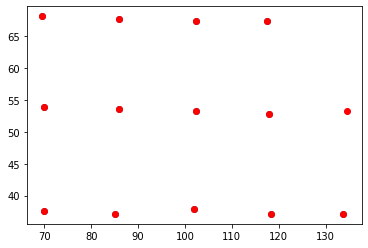

In [403]:
x1 = np.asarray(list(inverse_transform_coords.values())).transpose()[0] # inverse_coords.transpose()[0]
y1 = np.asarray(list(inverse_transform_coords.values())).transpose()[1] # inverse_coords.transpose()[1]
plt.scatter(x1,y1)
plt.scatter(x,y,c='r')
# the plot gives the expected result; all positions of the fraction tubes are accounted for

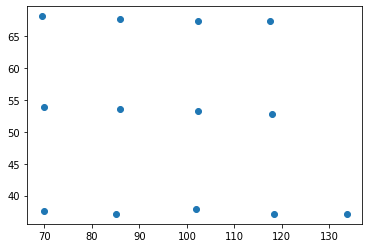

In [404]:
plt.scatter(x1,y1)

In [194]:
# real_prediction = l_scaler.inverse_transform(np.asarray(list(fraction_coords_polar.values())).reshape((14,2)))

In [169]:
inverse_transform_coords

{'fraction0': array([127.1204886 , -53.26062201]),
 'fraction1': array([125.00464741, -61.25650622]),
 'fraction2': array([125.43618405, -63.52395833]),
 'fraction3': array([125.32503726, -63.40105576]),
 'fraction4': array([121.24602145, -57.39520443]),
 'fraction5': array([133.31512645, -38.99643674]),
 'fraction6': array([132.25243565, -45.71399251]),
 'fraction7': array([133.19321202, -46.06449607]),
 'fraction8': array([132.32204695, -43.64646066]),
 'fraction9': array([125.52064854, -36.13039101]),
 'fraction10': array([137.60048791, -24.42833213]),
 'fraction11': array([136.77416605, -32.45157529]),
 'fraction12': array([137.41014513, -31.21866143]),
 'fraction13': array([134.7391543 , -24.99598625])}

In [170]:
test_coords

{'fraction0': array([69.96694215, 37.50617284]),
 'fraction1': array([85.14049587, 37.12345679]),
 'fraction2': array([102.        ,  37.88888889]),
 'fraction3': array([118.43801653,  37.12345679]),
 'fraction4': array([133.61157025,  37.12345679]),
 'fraction5': array([69.96694215, 53.96296296]),
 'fraction6': array([85.98347107, 53.58024691]),
 'fraction7': array([102.4214876 ,  53.19753086]),
 'fraction8': array([118.01652893,  52.81481481]),
 'fraction9': array([134.45454545,  53.19753086]),
 'fraction10': array([69.54545455, 68.12345679]),
 'fraction11': array([85.98347107, 67.74074074]),
 'fraction12': array([102.4214876 ,  67.35802469]),
 'fraction13': array([117.59504132,  67.35802469])}